In [715]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf

In [716]:
#inputs

#assets (yfinance ticker)
asset1='AAPL'
asset2='MSFT'
pairs='AAPL-MSFT' #insert name of asset 1 and asset 2

# trading period
start_trade='2022-01-10'
end_trade='2022-02-10'

#period of data collection
start_data='2017-11-19'
end_data='2020-11-19'

# comparison data
# compare with index 
#for tech stocks consider using QQQ or Nasdaq 100 or any other relevant index
#for crypto perhaps use bitcoin as index, cmc200, or QQQ (up to user judgement)
index_comp='QQQ'




In [717]:
#fetch log returns of pair (to model calibration)

X = yf.download(asset1, start = start_data, end=end_data)
X.reset_index(inplace=True)
X.tail()
X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
x = X['Log_Returns'].drop(labels=0, axis=0)
date=X['Date'].drop(labels=0,axis=0)
date=date.to_frame()




Y = yf.download(asset2, start = start_data, end=end_data)
Y.reset_index(inplace=True)
Y.tail()
Y['Log_Returns'] = np.log(Y['Adj Close']) - np.log(Y['Adj Close'].shift(1))
y = Y['Log_Returns'].drop(labels=0, axis=0)

#fit distribution to element in pair + probability integral transform to get marginal uniform

param1 = stats.t.fit(x)
dist1=stats.t(*param1)
u=dist1.cdf(x)
param2=stats.t.fit(y)
dist2=stats.t(*param2)
v=dist2.cdf(y)



#put returns in a data frame with corresponding dates
x_df=x.to_frame()
y_df=y.to_frame()

a=y_df.rename(columns={'Log_Returns': asset2})
b=x_df.rename(columns={'Log_Returns': asset1})

p =a.join(b)
x=p.join(date)

returns_df=x.set_index('Date')

print('Log returns for entire calibration period:')
returns_df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Log returns for entire calibration period:


,MSFT,AAPL
Date,,
2017-11-21,0.014316,0.018420
2017-11-22,-0.007313,0.010457
2017-11-24,0.001804,0.000057
2017-11-27,0.007300,-0.005042
2017-11-28,0.011970,-0.005876
...,...,...
2020-11-12,-0.005139,-0.002346
2020-11-13,0.004954,0.000419
2020-11-16,0.003320,0.008682


In [718]:
#dataframe of the returns for the specific trading period 

X_trade = yf.download(asset1, start =start_trade, end=end_trade)

X_trade.reset_index(inplace=True)
X_trade.tail()
X_trade['Log_Returns'] = np.log(X_trade['Adj Close']) - np.log(X_trade['Adj Close'].shift(1))
x_trade = X_trade['Log_Returns'].drop(labels=0, axis=0)
date=X_trade['Date'].drop(labels=0,axis=0)
date=date.to_frame()



Y_trade = yf.download(asset2, start = start_trade, end=end_trade)
Y_trade.reset_index(inplace=True)
Y_trade.tail()
Y_trade['Log_Returns'] = np.log(Y_trade['Adj Close']) - np.log(Y_trade['Adj Close'].shift(1))
y_trade = Y_trade['Log_Returns'].drop(labels=0, axis=0)


#put returns in a data frame with corresponding dates
x2_df=x_trade.to_frame()
y2_df=y_trade.to_frame()

m=y2_df.rename(columns={'Log_Returns': asset2})
a=x2_df.rename(columns={'Log_Returns': asset1})

p =m.join(a)
x=p.join(date)

returns_trade_period=x.set_index('Date')
print('Log returns for trading period:')
returns_trade_period


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Log returns for trading period:


,MSFT,AAPL
Date,,
2022-01-11,0.002257,0.016645
2022-01-12,0.010391,0.002567
2022-01-13,-0.043244,-0.019211
2022-01-14,0.017561,0.005098
2022-01-18,-0.024640,-0.019075
2022-01-19,0.002244,-0.021249
2022-01-20,-0.005720,-0.010401
2022-01-21,-0.018641,-0.012847
2022-01-24,0.001148,-0.004876


In [719]:
#fit bivariate copula family to data 
#calculate Akaike information criterion, Bayesion information criterion and KS value to help determine good fit

from co import *
import ndtest

pair=[pairs]
copulas_df = pd.DataFrame(index=pair, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])

    
best_aic = np.inf
best_copula= None


copulas=[GaussianCopula(),GumbelCopula(), ClaytonCopula(),FrankCopula()]
for copula in copulas:
    copula.fit(u,v)
    
    L = copula.log_likelihood(u,v)
    aic = 2 * copula.num_params - 2 * L
    if aic < best_aic:
        best_aic = aic
        best_bic = copula.num_params * np.log(len(u)) - 2 * L
        best_copula = copula

        # calculate KS-pvalue
        smp = copula.sample(size=len(u)) # generate sample from fit copula
        s_u = smp[:,0]
        s_v = smp[:,1]
        ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)

        if isinstance(copula, ArchimedeanCopula):
            best_param = copula.alpha
        else:
            best_param = copula.rho

copulas_df.loc[pair] = [best_copula.name, best_param, best_aic, best_bic, ks_pval]
copulas_df

/Users/SophiaZorek/Desktop/coding projects/Pairs Trading/co.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


,copula,parameter,aic,bic,KS_pvalue
AAPL-MSFT,Gaussian,0.72336,-700.34892,-695.723528,0.146775


In [720]:
# exit trade when pair reverts to historical relationship
# close position using criteria from'Pairs trading: A copula approach' - Liew, Wu, 2013
# paper link: https://link.springer.com/content/pdf/10.1057/jdhf.2013.1.pdf
# close positions when conditional probabilies cross boundery of 0.5

# rules for opening positions
# short position -> P(U<= u | V=v) >=c *A overpriced* AND P(V<= v | U=u) <=(1-c) *B underpriced*
# long position -> P(U<= u | V=v) <=(1-c) *A underpriced* AND P(V<= v | U=u) >=(c) *B overpriced*

from co import *
import ndtest
# calculate conditional probabilities
prob1=[]
prob2=[]
x=GaussianCopula()
algo_returns = {}
cl = 0.80

for u,v in zip(dist1.cdf(returns_trade_period[asset1]), dist2.cdf(returns_trade_period[asset2])):
    prob1.append(best_copula.cdf_u_given_v(u,v))
    prob2.append(best_copula.cdf_v_given_u(u,v))


probs_trade= pd.DataFrame(np.vstack([prob1,prob2]).T,index=returns_trade_period.index, columns=[asset1,asset2])



#calculate positions
positions=pd.DataFrame(index=probs_trade.index, columns = probs_trade.columns)
long = False
short = False


for t in positions.index:    
    # if long position is open
    if long:
        if (probs_trade.loc[t][asset1] > 0.5) or (probs_trade.loc[t][asset2] < 0.5):
            positions.loc[t] = [0,0]
            long = False
        else:
            positions.loc[t] = [1,-1]

    # if short position is open
    elif short:
        if (probs_trade.loc[t][asset1] < 0.5) or (probs_trade.loc[t][asset2] > 0.5):
            positions.loc[t] = [0,0]
            short = False
        else:
            positions.loc[t] = [-1,1]

    # if no positions are open
    else:
        if (probs_trade.loc[t][asset1] < (1-cl)) and (probs_trade.loc[t][asset2] > cl):
            # open long position
            positions.loc[t] = [1,-1]
            long = True
        elif (probs_trade.loc[t][asset1] > cl) and (probs_trade.loc[t][asset2] < (1-cl)):
            # open short positions
            positions.loc[t] = [-1,1]
            short = True
        else:
            positions.loc[t] = [0,0]


# calculate returns
algo_ret = (returns_trade_period * positions.shift()).sum(axis=1)
algo_returns[pairs] = algo_ret

print('Algorithm returns for trading period:')
algo_ret



Algorithm returns for trading period:


Date
2022-01-11    0.000000
2022-01-12    0.007824
2022-01-13   -0.000000
2022-01-14    0.000000
2022-01-18   -0.000000
2022-01-19    0.000000
2022-01-20   -0.004681
2022-01-21    0.005794
2022-01-24    0.000000
2022-01-25   -0.000000
2022-01-26    0.000000
2022-01-27   -0.013441
2022-01-28    0.039756
2022-01-31    0.000000
2022-02-01   -0.000000
2022-02-02    0.000000
2022-02-03   -0.000000
2022-02-04    0.000000
2022-02-07    0.012201
2022-02-08    0.000000
2022-02-09    0.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed


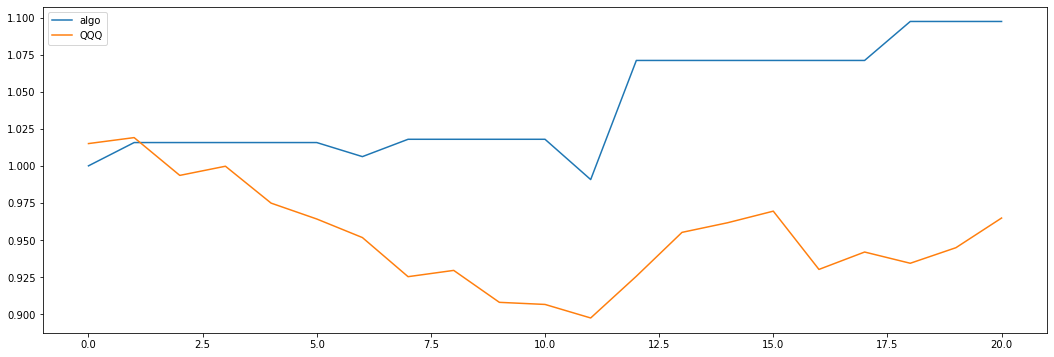

In [721]:
#Plot of algorithm returns vs. index return
#x-axis is # days from start of trading period
returns = pd.DataFrame.from_dict(algo_returns)
returns = np.exp(returns) - 1 # convert log-returns to simple returns
total_ret = returns.sum(axis=1) / len(returns.columns) * 2 # double capital (from short positions)

index_price = yf.download(index_comp, start=start_trade, end=end_trade)
index_price = index_price['Adj Close']
index_ret =index_price.pct_change().dropna()

plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(total_ret + 1), label='algo')
plt.plot(np.nancumprod(index_ret + 1), label=index_comp)
plt.legend()


In [722]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [723]:
#performance metrics
metrics = pd.DataFrame(index=['Algo', index_comp], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Length Drawdown'])
metrics.loc['Algo'] = calculate_metrics(np.nancumprod(total_ret + 1))
# metrics.loc[short_asset] = calculate_metrics(np.nancumprod(app_ret + 1))
metrics.loc[index_comp] = calculate_metrics(np.nancumprod(index_ret + 1))

metrics

,Total return,APR,Sharpe,Max Drawdown,Max Length Drawdown
Algo,0.097394,2.05035,3.873347,-0.026702,1.0
QQQ,-0.049479,-0.456073,-1.927251,-0.119401,19.0
